In [1]:
import os
import time
import math
import glob
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import h5py

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch

DEVICE = "cuda:0"
SAVE_PATH = 'model/unet_ba_22.pt'

# set device
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [2]:
## Creating the dataset

In [3]:
class ForestDataset(torch.utils.data.Dataset):
    
    '''Characterizes a dataset for PyTorch'''
    
    def __init__(self, path):
        '''Initialization'''
        # open dataset
        self.dset = h5py.File(path, 'r')
        self.ortho = self.dset['x_ortho']
        #self.dsm = self.dset['x_dsm']
        #self.dtm = self.dset['x_dtm']
        #self.slope = self.dset['x_slope']
        self.ground_truth = self.dset['x_ground_truth']
        
        # set number of samples
        self.length = self.ground_truth.shape[0]
        #self.labels = labels
        #self.list_IDs = list_IDs
        
        ## TODO:
        # make means and stds load from hdf5
        self.means = np.array([106.623276, 14.312894, 1325.6674, 29.272326])
        self.stds = np.array([54.006954, 12.487458, 16.26564, 7.691262])
        
        #self.transforms = T.Compose([T.ToTensor()])

    def __len__(self):
        '''Denotes the total number of samples'''
        return self.length

    def __getitem__(self, index):
        '''Generates one sample of data'''
        
        # Load data and get label
        X = torch.tensor(self.ortho[index], dtype=torch.float32).permute(2, 0, 1) / 255
        y = torch.tensor(self.ground_truth[index][:,:,0], dtype=torch.torch.int64)
        
        #X = torch.from_numpy(np.array(self.ortho[index]).transpose(2,0,1)) / 255
        #y = torch.from_numpy(np.array(self.ground_truth[index])[:,:,0], dtype=torch.torch.int64)

        return X, y #torch.from_numpy(y).permute(2, 0, 1)
        
        
    def show_item(self, index):
        '''shows the data'''
        #plt.imshow(np.array(self.ground_truth[index]))
        
        fig = plt.figure(figsize=(20,20))
        
        a = fig.add_subplot(1, 3, 1)
        imgplot = plt.imshow(np.array(self.ortho[index][:,:,:3]))
        a.set_title('RGB')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(1, 3, 2)
        imgplot = plt.imshow(np.array(np.roll(self.ortho[index], 1, axis=2)[:,:,:3]))
        a.set_title('CIR')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(1, 3, 3)
        imgplot = plt.imshow(np.array(self.ground_truth[index]), cmap="hot")
        imgplot.set_clim(0, 7)
        a.set_title('Ground Truth')
        plt.colorbar(ticks=[1, 2, 3, 4, 5, 6], orientation='horizontal')
        plt.axis('off')
        
        
    def close(self):
        ''' closes the hdf5 file'''
        self.dset.close()

In [4]:
#path_dataset = "/home/philipp/Data/dataset/dataset_256_ba.h5"
path_dataset = "/media/philipp/DATA/dataset/dataset_256_ba.h5"
data = ForestDataset(path_dataset)
len(data)

100000

In [5]:
X, y = data[1000]
X.shape, y.shape

(torch.Size([4, 256, 256]), torch.Size([256, 256]))

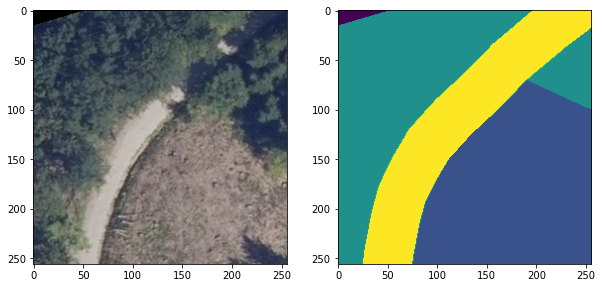

In [6]:
X, y = data[51]
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(X.permute(1, 2, 0).numpy()[:,:,:3])
ax[1].imshow(y.numpy())

In [7]:
# split data

In [8]:
batch_size = 16
validation_split = .1
test_split = .1
shuffle_dataset = True
random_seed = 12

# Creating data indices for training and validation splits:
dataset_size = 91000
#dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]

print(len(train_indices))
print(len(val_indices))
print(len(test_indices))

72800
9100
9100


In [9]:
# Creating PT data samplers and loaders:
train_sampler = sampler.SubsetRandomSampler(train_indices)
valid_sampler = sampler.SubsetRandomSampler(val_indices)

train_dl = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4, pin_memory=True)
valid_dl = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=4, pin_memory=True)

In [10]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([16, 4, 256, 256]), torch.Size([16, 256, 256]))

In [11]:
## Unet

In [12]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 64, 3, 1)
        self.conv2 = self.contract_block(64, 128, 3, 1)
        self.conv3 = self.contract_block(128, 256, 3, 1)
        self.conv4 = self.contract_block(256, 512, 3, 1)
        
        self.upconv4 = self.expand_block(512, 256, 3, 1)
        self.upconv3 = self.expand_block(256*2, 128, 3, 1)
        self.upconv2 = self.expand_block(128*2, 64, 3, 1)
        self.upconv1 = self.expand_block(64*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        upconv4 = self.upconv4(conv4)
        
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [13]:
# input 4 channels, output 2 classes
unet = UNET(4,5)

# try to load model
try:
    #unet = torch.load(Path('model/unet_typ.pkl'))
    unet.load_state_dict(torch.load(SAVE_PATH))
    unet.to(device)
except:
    pass

In [14]:
# testing one pass
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([16, 4, 256, 256]), torch.Size([16, 256, 256]))

In [15]:

#pred = unet(xb)
#pred.shape

In [16]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    # Reduce learning rate when a metric has stopped improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
    
    start = time.time()
    model.to(device)

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.to(device)
                y = y.to(device)
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    if device != 'cpu':
                        print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    else:
                        print('Current step: {}  Loss: {}  Acc: {}'.format(step, loss, acc))
                    # print(torch.cuda.memory_summary())
                    
            if phase == 'train':
                data_size = len(train_indices)
            else:
                data_size = len(val_indices)
                
            epoch_loss = running_loss / data_size
            epoch_acc = running_acc / data_size

            #clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)
            
            # save model
            torch.save(unet.state_dict(), SAVE_PATH)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.to(device)).float().mean()

In [36]:
# start training
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.001)
train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=25)

Epoch 0/24
----------
Current step: 100  Loss: 0.31212255358695984  Acc: 0.8837370872497559  AllocMem (Mb): 382.03759765625
Current step: 200  Loss: 0.27191874384880066  Acc: 0.9007153511047363  AllocMem (Mb): 382.03759765625
Current step: 300  Loss: 0.29640308022499084  Acc: 0.8958768844604492  AllocMem (Mb): 382.03759765625
Current step: 400  Loss: 0.3412971794605255  Acc: 0.8887085914611816  AllocMem (Mb): 382.03759765625
Current step: 500  Loss: 0.38002315163612366  Acc: 0.8505935668945312  AllocMem (Mb): 382.03759765625
Current step: 600  Loss: 0.38823309540748596  Acc: 0.8551473617553711  AllocMem (Mb): 382.03759765625
Current step: 700  Loss: 0.2794893682003021  Acc: 0.9169683456420898  AllocMem (Mb): 382.03759765625
Current step: 800  Loss: 0.23011881113052368  Acc: 0.9390687942504883  AllocMem (Mb): 382.03759765625
Current step: 900  Loss: 0.2333194762468338  Acc: 0.9219622611999512  AllocMem (Mb): 382.03759765625
Current step: 1000  Loss: 0.30195730924606323  Acc: 0.902602195

Current step: 600  Loss: 0.2523621916770935  Acc: 0.9064455032348633  AllocMem (Mb): 382.041015625
Current step: 700  Loss: 0.42230623960494995  Acc: 0.8337588310241699  AllocMem (Mb): 382.041015625
Current step: 800  Loss: 0.2570232152938843  Acc: 0.911311149597168  AllocMem (Mb): 382.041015625
Current step: 900  Loss: 0.4227331280708313  Acc: 0.8590927124023438  AllocMem (Mb): 382.041015625
Current step: 1000  Loss: 0.3679753541946411  Acc: 0.8550119400024414  AllocMem (Mb): 382.041015625
Current step: 1100  Loss: 0.40204599499702454  Acc: 0.8669118881225586  AllocMem (Mb): 382.041015625
Current step: 1200  Loss: 0.26266250014305115  Acc: 0.9076604843139648  AllocMem (Mb): 382.041015625
Current step: 1300  Loss: 0.35358738899230957  Acc: 0.8719906806945801  AllocMem (Mb): 382.041015625
Current step: 1400  Loss: 0.41247302293777466  Acc: 0.858116626739502  AllocMem (Mb): 382.041015625
Current step: 1500  Loss: 0.30880215764045715  Acc: 0.8964929580688477  AllocMem (Mb): 382.041015625


Current step: 1100  Loss: 0.2647298574447632  Acc: 0.9144535064697266  AllocMem (Mb): 382.0439453125
Current step: 1200  Loss: 0.5241248607635498  Acc: 0.8264117240905762  AllocMem (Mb): 382.0439453125
Current step: 1300  Loss: 0.2964189052581787  Acc: 0.8977980613708496  AllocMem (Mb): 382.0439453125
Current step: 1400  Loss: 0.34289902448654175  Acc: 0.8714580535888672  AllocMem (Mb): 382.0439453125
Current step: 1500  Loss: 0.2782122790813446  Acc: 0.8975701332092285  AllocMem (Mb): 382.0439453125
Current step: 1600  Loss: 0.30828437209129333  Acc: 0.8875775337219238  AllocMem (Mb): 382.0439453125
Current step: 1700  Loss: 0.1994652897119522  Acc: 0.9410357475280762  AllocMem (Mb): 382.0439453125
Current step: 1800  Loss: 0.3049885630607605  Acc: 0.9015474319458008  AllocMem (Mb): 382.0439453125
Current step: 1900  Loss: 0.3969753384590149  Acc: 0.869962215423584  AllocMem (Mb): 382.0439453125
Current step: 2000  Loss: 0.22812776267528534  Acc: 0.9305305480957031  AllocMem (Mb): 382

Current step: 1600  Loss: 0.3789013624191284  Acc: 0.8814797401428223  AllocMem (Mb): 382.046875
Current step: 1700  Loss: 0.2379373162984848  Acc: 0.9274477958679199  AllocMem (Mb): 382.046875
Current step: 1800  Loss: 0.40572723746299744  Acc: 0.8850769996643066  AllocMem (Mb): 382.046875
Current step: 1900  Loss: 0.4796496629714966  Acc: 0.8306975364685059  AllocMem (Mb): 382.046875
Current step: 2000  Loss: 0.3349244296550751  Acc: 0.8676486015319824  AllocMem (Mb): 382.046875
Current step: 2100  Loss: 0.35616594552993774  Acc: 0.8567214012145996  AllocMem (Mb): 382.046875
Current step: 2200  Loss: 0.2903346121311188  Acc: 0.8994531631469727  AllocMem (Mb): 382.046875
Epoch 9/24
----------
train Loss: 0.3297 Acc: 0.8859235644340515
----------
Current step: 100  Loss: 0.2547479569911957  Acc: 0.9250507354736328  AllocMem (Mb): 382.04736328125
Current step: 200  Loss: 0.19751359522342682  Acc: 0.9415535926818848  AllocMem (Mb): 382.04736328125
Epoch 9/24
----------
valid Loss: 0.3276

Current step: 2100  Loss: 0.37392890453338623  Acc: 0.8583645820617676  AllocMem (Mb): 382.0498046875
Current step: 2200  Loss: 0.3017065227031708  Acc: 0.8717761039733887  AllocMem (Mb): 382.0498046875
Epoch 12/24
----------
train Loss: 0.3281 Acc: 0.886428952217102
----------
Current step: 100  Loss: 0.29363033175468445  Acc: 0.8845691680908203  AllocMem (Mb): 382.05029296875
Current step: 200  Loss: 0.32085520029067993  Acc: 0.8733081817626953  AllocMem (Mb): 382.05029296875
Epoch 12/24
----------
valid Loss: 0.3277 Acc: 0.8886288404464722
----------
Epoch 13/24
----------
Current step: 100  Loss: 0.2600669264793396  Acc: 0.8857007026672363  AllocMem (Mb): 382.05078125
Current step: 200  Loss: 0.3436146676540375  Acc: 0.8685712814331055  AllocMem (Mb): 382.05078125
Current step: 300  Loss: 0.2611004114151001  Acc: 0.9280486106872559  AllocMem (Mb): 382.05078125
Current step: 400  Loss: 0.34645023941993713  Acc: 0.9071159362792969  AllocMem (Mb): 382.05078125
Current step: 500  Loss:

Epoch 15/24
----------
valid Loss: 0.3267 Acc: 0.888579785823822
----------
Epoch 16/24
----------
Current step: 100  Loss: 0.24960896372795105  Acc: 0.9189009666442871  AllocMem (Mb): 382.0537109375
Current step: 200  Loss: 0.2277284562587738  Acc: 0.9304275512695312  AllocMem (Mb): 382.0537109375
Current step: 300  Loss: 0.3363950550556183  Acc: 0.8882856369018555  AllocMem (Mb): 382.0537109375
Current step: 400  Loss: 0.688977837562561  Acc: 0.788966178894043  AllocMem (Mb): 382.0537109375
Current step: 500  Loss: 0.3697093427181244  Acc: 0.8654360771179199  AllocMem (Mb): 382.0537109375
Current step: 600  Loss: 0.3710390031337738  Acc: 0.8694214820861816  AllocMem (Mb): 382.0537109375
Current step: 700  Loss: 0.30448117852211  Acc: 0.8810305595397949  AllocMem (Mb): 382.0537109375
Current step: 800  Loss: 0.4314223527908325  Acc: 0.8465337753295898  AllocMem (Mb): 382.0537109375
Current step: 900  Loss: 0.3402433693408966  Acc: 0.8860015869140625  AllocMem (Mb): 382.0537109375
Curr

Current step: 500  Loss: 0.25428062677383423  Acc: 0.9298496246337891  AllocMem (Mb): 382.056640625
Current step: 600  Loss: 0.3762223422527313  Acc: 0.8638157844543457  AllocMem (Mb): 382.056640625
Current step: 700  Loss: 0.2750646770000458  Acc: 0.9124336242675781  AllocMem (Mb): 382.056640625
Current step: 800  Loss: 0.5433024764060974  Acc: 0.7957243919372559  AllocMem (Mb): 382.056640625
Current step: 900  Loss: 0.29514339566230774  Acc: 0.8989162445068359  AllocMem (Mb): 382.056640625
Current step: 1000  Loss: 0.19299107789993286  Acc: 0.9421215057373047  AllocMem (Mb): 382.056640625
Current step: 1100  Loss: 0.2797909379005432  Acc: 0.912992000579834  AllocMem (Mb): 382.056640625
Current step: 1200  Loss: 0.2913593053817749  Acc: 0.8893446922302246  AllocMem (Mb): 382.056640625
Current step: 1300  Loss: 0.23027217388153076  Acc: 0.9010043144226074  AllocMem (Mb): 382.056640625
Current step: 1400  Loss: 0.36191314458847046  Acc: 0.8841743469238281  AllocMem (Mb): 382.056640625
C

Current step: 1000  Loss: 0.21868835389614105  Acc: 0.9268283843994141  AllocMem (Mb): 382.0595703125
Current step: 1100  Loss: 0.25835156440734863  Acc: 0.9048886299133301  AllocMem (Mb): 382.0595703125
Current step: 1200  Loss: 0.2289094179868698  Acc: 0.9336342811584473  AllocMem (Mb): 382.0595703125
Current step: 1300  Loss: 0.4509550631046295  Acc: 0.8341031074523926  AllocMem (Mb): 382.0595703125
Current step: 1400  Loss: 0.4028856158256531  Acc: 0.8760433197021484  AllocMem (Mb): 382.0595703125
Current step: 1500  Loss: 0.3970020115375519  Acc: 0.8572368621826172  AllocMem (Mb): 382.0595703125
Current step: 1600  Loss: 0.213344007730484  Acc: 0.937220573425293  AllocMem (Mb): 382.0595703125
Current step: 1700  Loss: 0.3991992175579071  Acc: 0.8450446128845215  AllocMem (Mb): 382.0595703125
Current step: 1800  Loss: 0.31586191058158875  Acc: 0.8682360649108887  AllocMem (Mb): 382.0595703125
Current step: 1900  Loss: 0.3055972456932068  Acc: 0.9005122184753418  AllocMem (Mb): 382.

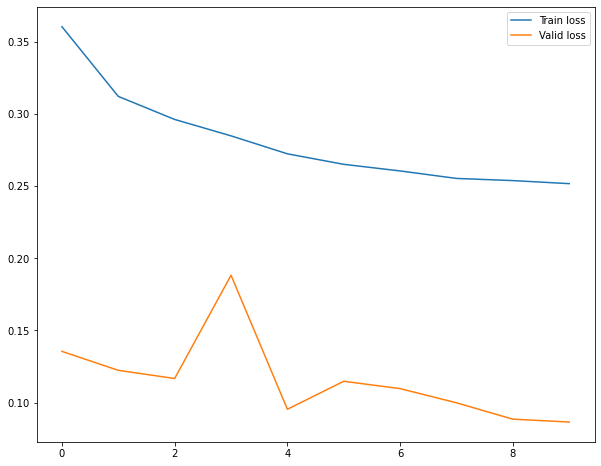

In [18]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

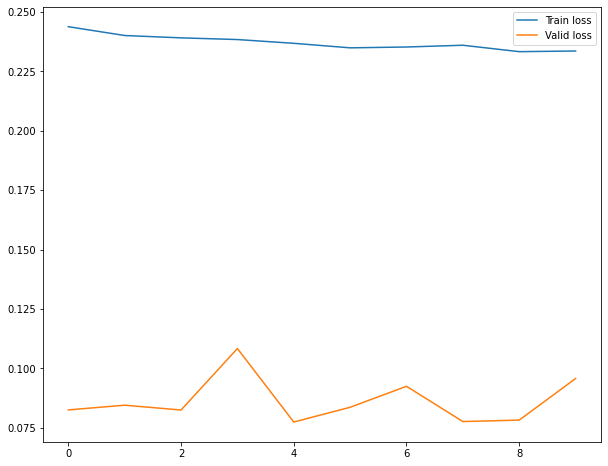

In [18]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

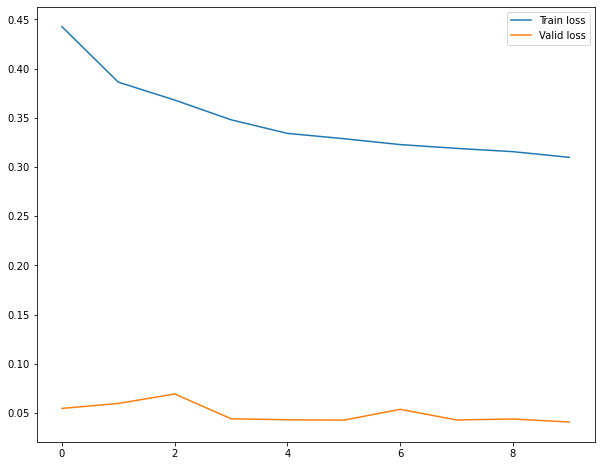

In [18]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

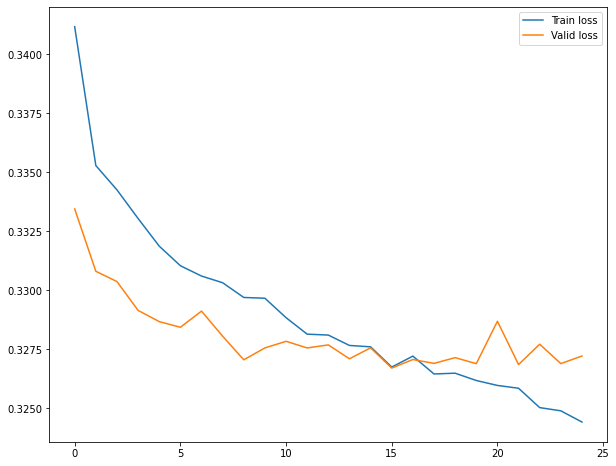

In [37]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

In [18]:
# predict

In [17]:
xb, yb = next(iter(train_dl))

In [18]:
xb.shape

torch.Size([16, 4, 256, 256])

In [19]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [32]:
xb, yb = next(iter(valid_dl))

with torch.no_grad():
    predb = unet(xb.to(device))

predb.shape

torch.Size([16, 5, 256, 256])

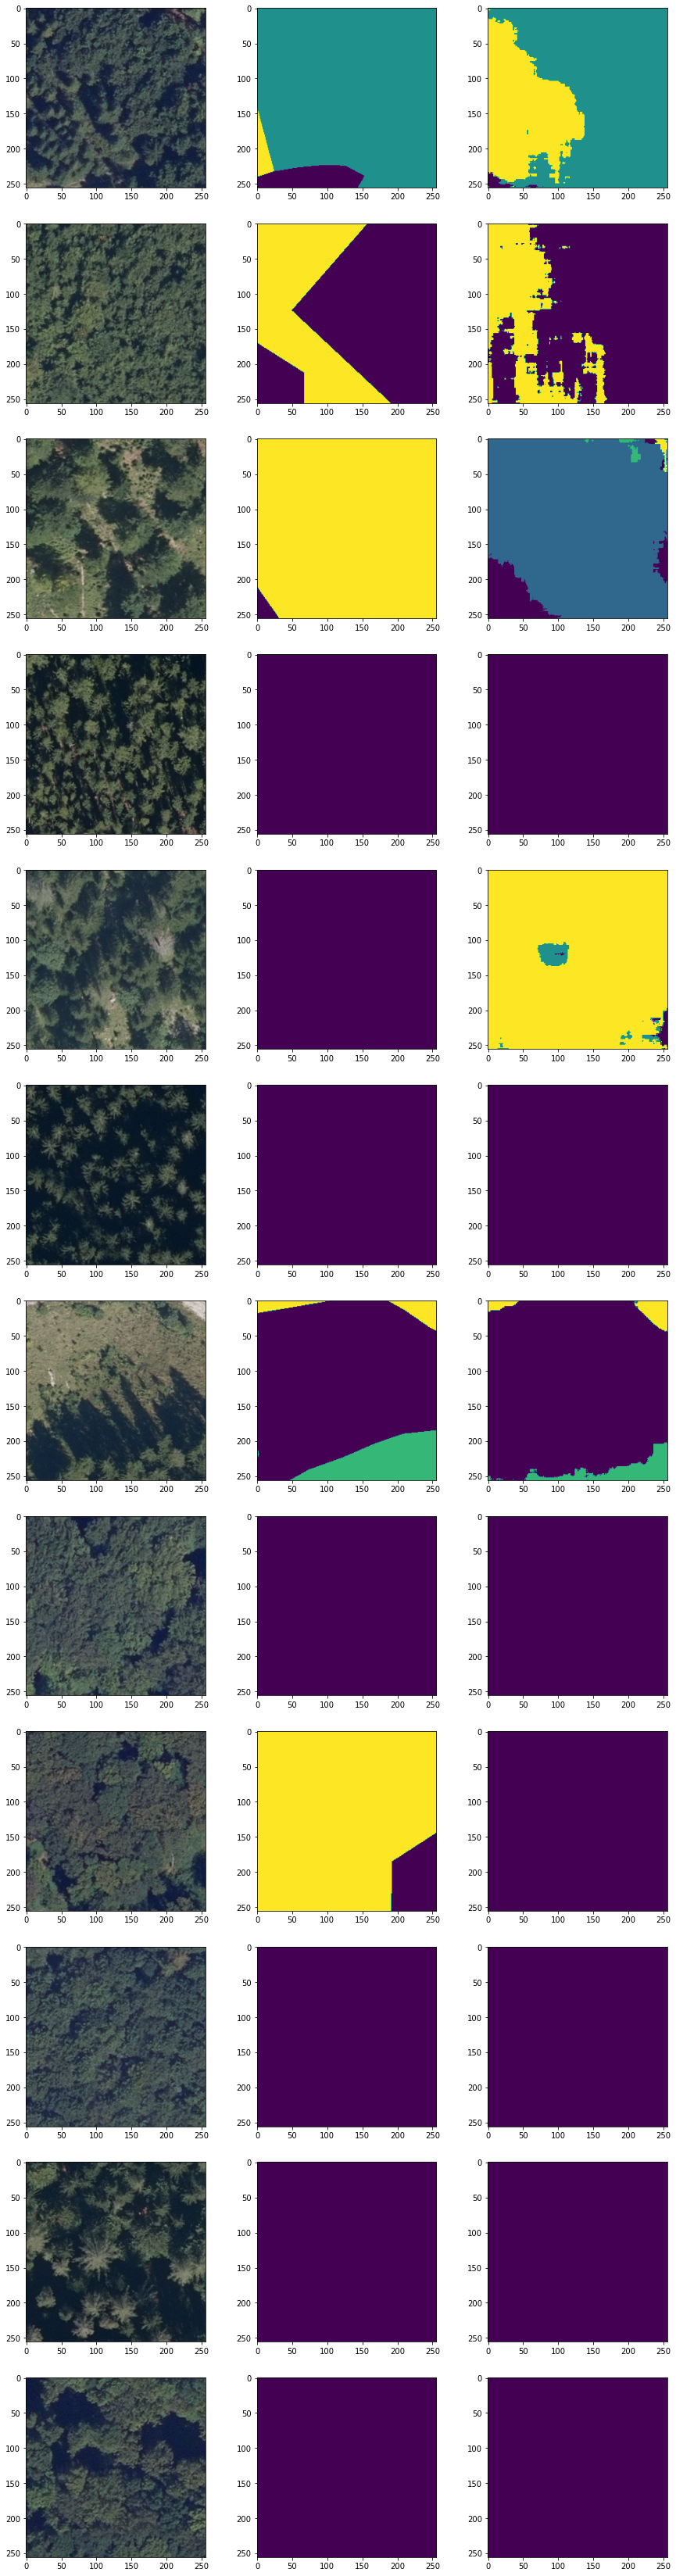

In [33]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [24]:
# save using pickle
#torch.save(unet,Path('model/unet_typ.pkl'))

# save 
torch.save(unet.state_dict(), SAVE_PATH)